In [684]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [685]:
pd.set_option('display.max_rows', 10)

In [686]:
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

My project is a VPIN trading strategy. This strategy revoleves around generating alpha from trading flow analysis.\
An easy summary is that we get returns, regress against rolling trade flow, and trade when predicted returns are higher than a set level.\
Technically, I don't think this is exactly a VPIN strategy. By doing some research, it seems that VPINs understand that the market is not completely represented on public exchanges (for non-crypto anyway) and that even if a trade is made on the ask, it could potentially not have been buyer initiated because of rapid price movements. Therefore, the VPIN strategy usualy involves looking at volume candles and assigning proportional volume to positive or negative trade flow depending on the close price relative to the high and low. In our dataset, the "buy" or "sell" side was given. This means that we do not have to do these approximations and can have a very accurate trade flow calculation.

# Importing Data

For this step, I used crypto pairs data from 2021, 2022 and 2023:\
-BTC VS USD\
-ETH VS BTC\
-ETH VS USD

The data was not in seconds are not uniformly spread out (as expected people are not trading on exactly regular intervals). This isnt an issue. After modifying the data indeces and columns as you see below, I resapled the data over each second. This gives us the total flow each second over the sample.

The 'Tradeflow' column was calculated using a simple multiplicative operation.

In [687]:
pd.set_option('display.max_rows', 10)

To give an idea of what the original data looks like:

In [480]:
BTC_USD_2023 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_BTC-USD_2023.delim.gz", delimiter = '\t')
BTC_USD_2023

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1674521267814309000,1674521267874527000,22970120000,87069600,-1
1,1674521267814046000,1674521267874527000,22970150000,25797600,-1
2,1674521267817981000,1674521267878712000,22970120000,10,-1
3,1674521267822734000,1674521267886114000,22969160000,217683140,-1
4,1674521274845338000,1674521268676444000,22969840000,10000000,1
...,...,...,...,...,...
560102,1674661801474245000,1674661801477570000,22573080000,920730,1
560103,1674661801534824000,1674661801543105000,22571970000,335000000,-1
560104,1674661801592039000,1674661801601688000,22570920000,50000000,-1
560105,1674661801592674000,1674661801601719000,22570920000,32600000,-1


In [688]:
BTC_USD_2023 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_BTC-USD_2023.delim.gz", delimiter = '\t')
ETH_BTC_2023 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_ETH-BTC_2023.delim.gz", delimiter = '\t')
ETH_USD_2023 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_ETH-USD_2023.delim.gz", delimiter = '\t')
BTC_USD_2022 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_BTC-USD_2022.delim.gz", delimiter = '\t')
ETH_BTC_2022 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_ETH-BTC_2022.delim.gz", delimiter = '\t')
ETH_USD_2022 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_ETH-USD_2022.delim.gz", delimiter = '\t')
BTC_USD_2021 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_BTC-USD_2021.delim.gz", delimiter = '\t')
ETH_BTC_2021 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_ETH-BTC_2021.delim.gz", delimiter = '\t')
ETH_USD_2021 = pd.read_csv("/Users/pierrevivier/Desktop/trades_narrow_ETH-USD_2021.delim.gz", delimiter = '\t')

dfs = [BTC_USD_2023,ETH_BTC_2023,ETH_USD_2023,BTC_USD_2022,ETH_BTC_2022,ETH_USD_2022,BTC_USD_2021,ETH_BTC_2021,ETH_USD_2021]
#I store the dataframes inside a list for easier manipulation
for i in range(len(dfs)):
    dfs[i].index = pd.to_datetime((dfs[i]['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
    dfs[i].index = dfs[i].index.rename('time')

for i in range(len(dfs)):
    dfs[i]['Tradeflow'] = dfs[i]['PriceMillionths']*dfs[i]['SizeBillionths'] * np.sign(dfs[i]['Side'])
    
for i in range(len(dfs)):
    dfs[i] = dfs[i].resample('1S').agg({'PriceMillionths':'last','SizeBillionths':'sum','Tradeflow':'sum'})
    
#for i in range(len(dfs)):
#    dfs[i]['TradeflowMean'] = dfs[i]['Tradeflox'].rollin(30).mean()

    

    
    
BTC_USD_2023 = dfs[0]
ETH_BTC_2023 = dfs[1]
ETH_USD_2023 = dfs[2]
BTC_USD_2022 = dfs[3]
ETH_BTC_2022 = dfs[4]
ETH_USD_2022 = dfs[5]
BTC_USD_2021 = dfs[6]
ETH_BTC_2021 = dfs[7]
ETH_USD_2021 = dfs[8]
    

In [482]:
BTC_USD_2022

,PriceMillionths,SizeBillionths,Tradeflow
time,,,
2022-01-29 21:02:49,3.839104e+10,260015400,9.982032e+18
2022-01-29 21:02:50,3.839456e+10,165936820,4.299443e+18
2022-01-29 21:02:51,3.838189e+10,144903700,-5.397144e+18
2022-01-29 21:02:52,3.838875e+10,15137200,-5.703130e+16
2022-01-29 21:02:53,3.838263e+10,4528110,9.703062e+16
...,...,...,...
2022-02-05 01:29:51,4.139201e+10,209535020,2.385051e+18
2022-02-05 01:29:52,4.139810e+10,14826440,6.137498e+17
2022-02-05 01:29:53,4.139831e+10,90899050,-3.423022e+18


# Visualizing our datasets

Import part of the process to look at graphs that are human-readable to get an idea of what we are working with.

One main motivation I have to run these graphs is to see if there are very large differences between the years, and if some parts of the data are clealy different from one-another.

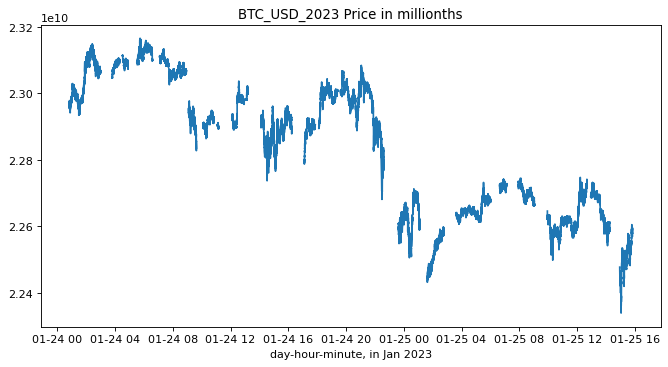

In [483]:
figure(figsize=(10, 5), dpi=80)
plt.xlabel('day-hour-minute, in Jan 2023')
plt.title('BTC_USD_2023 Price in millionths')
plt.plot(BTC_USD_2023['PriceMillionths'])

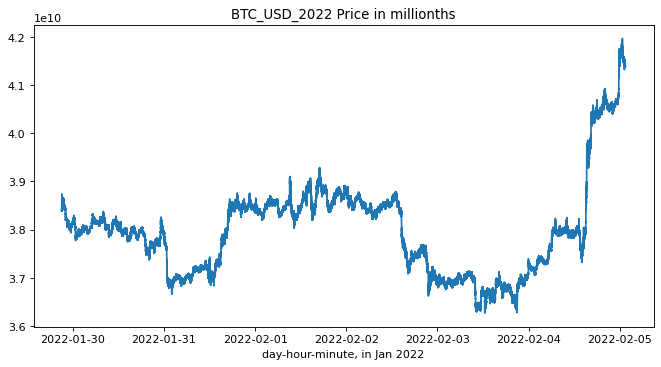

In [484]:
figure(figsize=(10, 5), dpi=80)
plt.xlabel('day-hour-minute, in Jan 2022')
plt.title('BTC_USD_2022 Price in millionths')
plt.plot(BTC_USD_2022['PriceMillionths'])

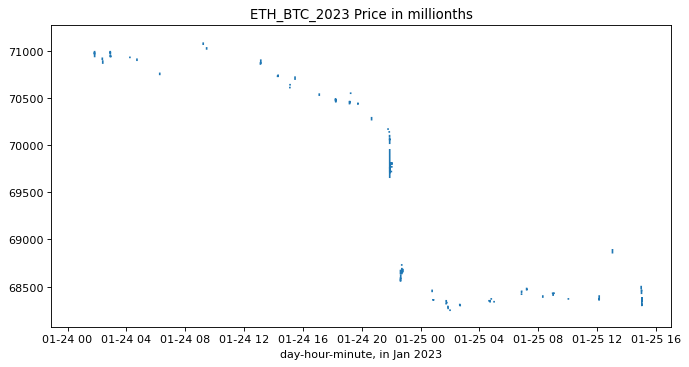

In [485]:
figure(figsize=(10, 5), dpi=80)
plt.xlabel('day-hour-minute, in Jan 2023')
plt.title('ETH_BTC_2023 Price in millionths')
plt.plot(ETH_BTC_2023['PriceMillionths'])

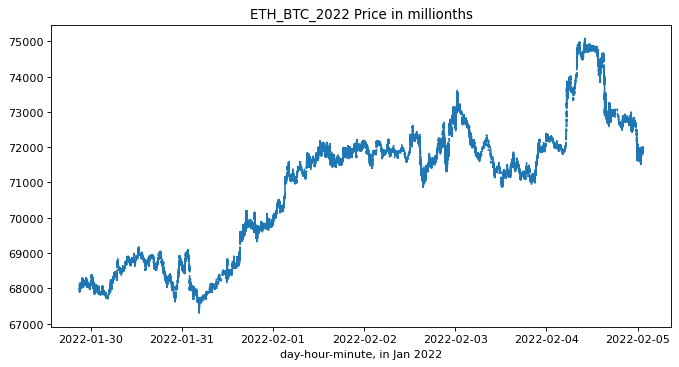

In [486]:
figure(figsize=(10, 5), dpi=80)
plt.xlabel('day-hour-minute, in Jan 2022')
plt.title('ETH_BTC_2022 Price in millionths')
plt.plot(ETH_BTC_2022['PriceMillionths'])

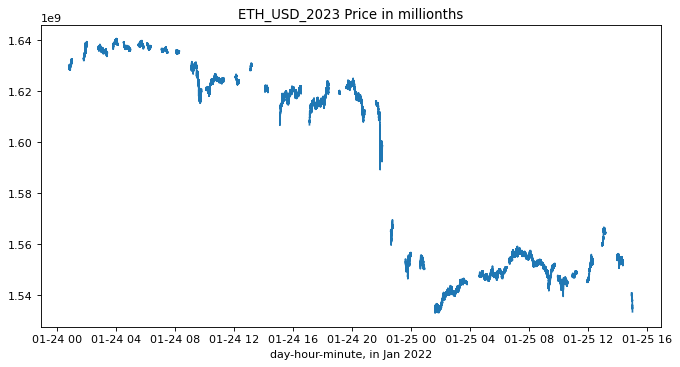

In [487]:
figure(figsize=(10, 5), dpi=80)
plt.xlabel('day-hour-minute, in Jan 2022')
plt.title('ETH_USD_2023 Price in millionths')
plt.plot(ETH_USD_2023['PriceMillionths'])

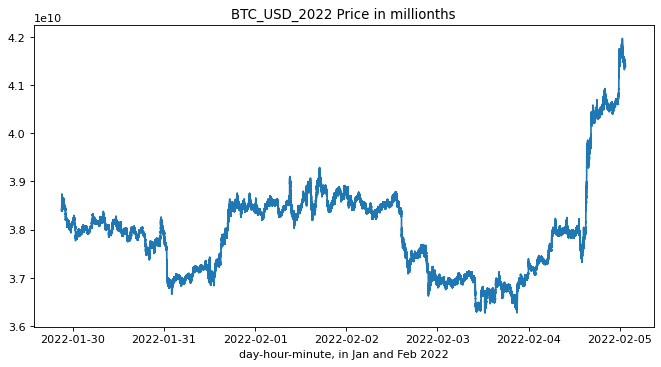

In [488]:
figure(figsize=(10, 5), dpi=80)
plt.xlabel('day-hour-minute, in Jan and Feb 2022')
plt.title('BTC_USD_2022 Price in millionths')
plt.plot(BTC_USD_2022['PriceMillionths'])

I looked at all the graphs, but they are not all of interest, so I'll link the rest in the annex of the powerpoint and the end of this notebook.

The most interesting graphs is the ETH_BTC 2023 graph, where our resapling clearly shows that our data is sparse. This should not be an issue for our VPIN strategy, but we shall see. I remove the NaNs in the dataframes, but after the tradeflow graphs in case they give us insights.

Next are the tradeflow graphs.

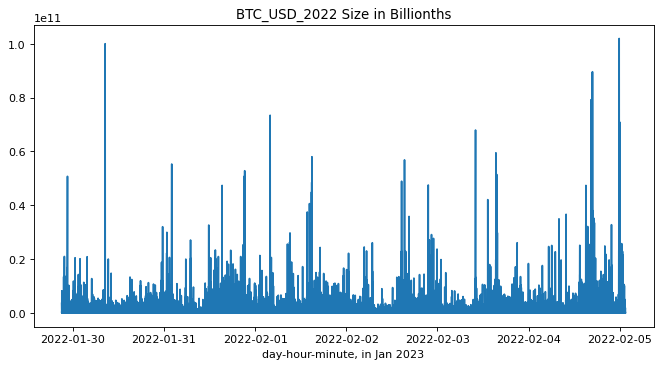

In [489]:
figure(figsize=(10, 5), dpi=80)
plt.xlabel('day-hour-minute, in Jan 2023')
plt.title('BTC_USD_2022 Size in Billionths')
plt.plot(BTC_USD_2022['SizeBillionths'])

I have tried to visualize these as a rolling mean or as tradeflow, but overall the only thing I got out of them was that certain seconds have much larger orders than others - but that isnt unexpected.

In [689]:
dfs = [BTC_USD_2023,ETH_BTC_2023,ETH_USD_2023,BTC_USD_2022,ETH_BTC_2022,ETH_USD_2022,BTC_USD_2021,ETH_BTC_2021,ETH_USD_2021]

for i in range(len(dfs)):
    dfs[i]=dfs[i].dropna(axis=0)
    dfs[i]['returns'] = dfs[i]['PriceMillionths'].pct_change()
    dfs[i]=dfs[i].dropna(axis=0)
    

BTC_USD_2023 = dfs[0]
ETH_BTC_2023 = dfs[1]
ETH_USD_2023 = dfs[2]
BTC_USD_2022 = dfs[3]
ETH_BTC_2022 = dfs[4]
ETH_USD_2022 = dfs[5]
BTC_USD_2021 = dfs[6]
ETH_BTC_2021 = dfs[7]
ETH_USD_2021 = dfs[8]


In [668]:
BTC_USD_2023

,PriceMillionths,SizeBillionths,Tradeflow,returns,rollingTradeflow
time,,,,,
2023-01-24 00:48:20,2.296535e+10,734908420,-1.687729e+19,-9.970550e-05,-1.008971e+18
2023-01-24 00:48:21,2.296666e+10,1496090,3.436019e+16,5.704246e-05,-3.129930e+19
2023-01-24 00:48:22,2.296426e+10,801820,-1.841320e+16,-1.044993e-04,-3.827184e+19
2023-01-24 00:48:23,2.296732e+10,105256170,2.417380e+18,1.332505e-04,-3.804036e+19
2023-01-24 00:48:24,2.296768e+10,40138130,9.218850e+17,1.567445e-05,-3.622483e+19
...,...,...,...,...,...
2023-01-25 15:49:57,2.257980e+10,50775320,1.146496e+18,4.428739e-07,1.242400e+19
2023-01-25 15:49:58,2.257946e+10,828210210,-1.869213e+19,-1.505771e-05,1.314745e+19
2023-01-25 15:49:59,2.257918e+10,592230,1.337207e+16,-1.240065e-05,-6.730789e+18


# The Strategy

Here is the code for the VPIN strategy. I have coded a long-only, long-short and a double strategy. I explain each one when required. The code is annotated for clarity.

Here are the basics for the long-only strategy.

I split the data on training and testing sets, chronologically.

With the training data, I generate a beta for predicted returns using rolling tradeflow.

Using this beta, I predict returns on the test data.

When out test data return predictions are above a predetermined level, I enter the trade. When the returns are predicted to go back down, I exit the trade.

As a reminder, this is what the data looks like.

In [493]:
BTC_USD_2023

,PriceMillionths,SizeBillionths,Tradeflow,returns
time,,,,
2023-01-24 00:47:48,2.296767e+10,273053410,6.211442e+18,-6.486959e-05
2023-01-24 00:47:49,2.297080e+10,589020180,1.341303e+19,1.362785e-04
2023-01-24 00:47:50,2.297304e+10,305021280,7.006904e+18,9.751511e-05
2023-01-24 00:47:51,2.297434e+10,1610050380,-2.498973e+17,5.658807e-05
2023-01-24 00:47:52,2.297323e+10,26198090,6.018544e+17,-4.831477e-05
...,...,...,...,...
2023-01-25 15:49:57,2.257980e+10,50775320,1.146496e+18,4.428739e-07
2023-01-25 15:49:58,2.257946e+10,828210210,-1.869213e+19,-1.505771e-05
2023-01-25 15:49:59,2.257918e+10,592230,1.337207e+16,-1.240065e-05


In [592]:
VPIN(BTC_USD_2022,30,0.5)

,PriceMillionths,SizeBillionths,Tradeflow,returns,rollingTradeflow,pred_returns,trigger,Cash,Position,Pnl,cumpnl
time,,,,,,,,,,,
2022-02-03 05:53:18,3.697001e+10,8155590,3.015122e+17,0.000000,-1.334931e+19,-2.711903e-07,0,0.0,0.0,0.0,0.000000
2022-02-03 05:53:19,3.697001e+10,3602390,1.331804e+17,0.000000,-1.311693e+19,-2.664695e-07,0,0.0,0.0,0.0,0.000000
2022-02-03 05:53:20,3.698295e+10,563800810,2.084668e+19,0.000350,-1.318470e+19,-2.678461e-07,0,0.0,0.0,0.0,0.000000
2022-02-03 05:53:21,3.697727e+10,68227180,-2.457161e+18,-0.000154,7.392586e+18,1.501798e-07,0,0.0,0.0,0.0,0.000000
2022-02-03 05:53:23,3.697873e+10,134700,4.981035e+15,0.000039,1.315570e+19,2.672571e-07,0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-05 01:29:51,4.139201e+10,209535020,2.385051e+18,0.000216,-1.731604e+19,-3.517740e-07,0,0.0,0.0,0.0,0.035806
2022-02-05 01:29:52,4.139810e+10,14826440,6.137498e+17,0.000147,-1.359651e+19,-2.762122e-07,0,0.0,0.0,0.0,0.035806
2022-02-05 01:29:53,4.139831e+10,90899050,-3.423022e+18,0.000005,-9.689482e+18,-1.968411e-07,0,0.0,0.0,0.0,0.035806


In [623]:
def VPIN(dataset, window, j):
    
    #this part calculates a rolling trade flow based on the window input
    dataset['rollingTradeflow'] = dataset['Tradeflow'].rolling(window,closed = 'left').sum()
    dataset=dataset.dropna(axis=0)
    
    #this part splits the data for training and testing purposes
    train, test = train_test_split(dataset, test_size=0.3,shuffle = False)
    beta = sm.OLS(train['returns'],train['rollingTradeflow']).fit().params[0]
    
    #this part predicts the returns with our beta and tradeflow
    test['pred_returns'] = test['rollingTradeflow'] * beta
    dataset = test
    
    #this is the calculation of the level and trigger
    levelhigh = dataset['pred_returns'].mean() + dataset['pred_returns'].std()*j
    levellow = dataset['pred_returns'].mean() + dataset['pred_returns'].std()*j/2
    dataset['trigger'] = np.where(dataset['pred_returns']>levelhigh, 1, 0)
    dataset['exit'] = np.where(dataset['pred_returns']>levellow, 1, 0)
    
    df = dataset.copy()
    df['Cash']=0.0
    df['Position']=0.0
    df['Pnl']=0.0
    tradetracker = 0
    for today in df.index:
        
        #if on first day we need to enter, then enter into a trade
        if today == df.index[0]:
            if df.loc[today,'trigger'] > 0:
                df.loc[today,'Position'] = 1 / df.loc[today,'PriceMillionths']
                df.loc[today,'Cash'] = - 1 
                tradetracker += 1
        
        #if on last day we still hold equity, sell it off
        elif today == df.index[-1]:
            if df.loc[yesterday,'Position'] >0.0:
                df.loc[today,'Cash'] = df.loc[yesterday,'Position'] * df.loc[today,'PriceMillionths'] 
                df.loc[today,'Position'] = 0.0
                df.loc[today,'Pnl'] = df.loc[today,'Cash'] - 1
                tradetracker +1
        else:
            
            #if we are not holding anything and the expected future returns are high enough, enter trade
            if df.loc[today,'trigger'] > 0 and df.loc[yesterday,'Position']==0: 
                df.loc[today,'Position'] = 1 / df.loc[today,'PriceMillionths']
                df.loc[today,'Cash'] = - 1
                tradetracker += 1
                
            #if we are holding equity but the predicted returns are low enough, exit position
            elif df.loc[today,'exit'] == 0 and df.loc[yesterday,'Position']>0.0: 
                df.loc[today,'Cash'] = df.loc[yesterday,'Position'] * df.loc[today,'PriceMillionths']    
                df.loc[today,'Position'] = 0.0
                df.loc[today,'Pnl'] = df.loc[today,'Cash'] - 1

                tradetracker += 1
            
            #if we are holding but predicted returns are still high, hold
            else:
                df.loc[today,'Position'] = df.loc[yesterday,'Position'] 
        yesterday=today
    df['cumpnl'] = df['Pnl'].cumsum()
    return [df,tradetracker]


Here is a sample output for the BTC_USD dataset.

In [625]:
sample = VPIN(BTC_USD_2022,30,0.5)

In [626]:
sample[0]

,PriceMillionths,SizeBillionths,Tradeflow,returns,rollingTradeflow,pred_returns,trigger,exit,Cash,Position,Pnl,cumpnl
time,,,,,,,,,,,,
2022-02-03 05:53:18,3.697001e+10,8155590,3.015122e+17,0.000000,-1.334931e+19,-2.711903e-07,0,0,0.0,0.0,0.0,0.000000
2022-02-03 05:53:19,3.697001e+10,3602390,1.331804e+17,0.000000,-1.311693e+19,-2.664695e-07,0,0,0.0,0.0,0.0,0.000000
2022-02-03 05:53:20,3.698295e+10,563800810,2.084668e+19,0.000350,-1.318470e+19,-2.678461e-07,0,0,0.0,0.0,0.0,0.000000
2022-02-03 05:53:21,3.697727e+10,68227180,-2.457161e+18,-0.000154,7.392586e+18,1.501798e-07,0,0,0.0,0.0,0.0,0.000000
2022-02-03 05:53:23,3.697873e+10,134700,4.981035e+15,0.000039,1.315570e+19,2.672571e-07,0,0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-05 01:29:51,4.139201e+10,209535020,2.385051e+18,0.000216,-1.731604e+19,-3.517740e-07,0,0,0.0,0.0,0.0,0.042023
2022-02-05 01:29:52,4.139810e+10,14826440,6.137498e+17,0.000147,-1.359651e+19,-2.762122e-07,0,0,0.0,0.0,0.0,0.042023
2022-02-05 01:29:53,4.139831e+10,90899050,-3.423022e+18,0.000005,-9.689482e+18,-1.968411e-07,0,0,0.0,0.0,0.0,0.042023


In [627]:
sample[1]

3700

This shows that the pnl was 4.2% over 3700 trades for a window of 30 seconds and a j equal to 0.5.

Now we will seek to optimize over the window and over the level (the level is determined by j).

In [780]:
np.arange(0,3,0.5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5])

This function finds the optimal window and j for a training dataset, for the long or double strategy.

In [969]:
def find_optimal(dataset,long_or_double):
    
    df = pd.DataFrame(columns =[0,0.5,1,1.5,2,2.5] , index = [5,10,30,50,100,200,500])
    train, test = train_test_split(dataset, test_size=0.3,shuffle = False)
    ma = 0
    if long_or_double=='long':
        
        #looping over windows
        for w in [5,10,30,50,100,200,500]:
            print('1/8')
            
            #looping over levels
            for j in np.arange(0,3,0.5):
                print('lap 1')
                df.loc[w,j] = VPIN(train, w, j)[0]['cumpnl'][-1]
                if df.loc[w,j]>ma:
                    finalw = w
                    finalj = j
                    ma = df.loc[w,j]
    if long_or_double=='double':
        for w in [5,10,30,50,100,200,500]:
            print('1/8')
            for j in np.arange(0,3,0.5):
                df.loc[w,j] = VPINdouble(train, w, j)[0]['cumpnl'][-1]
                if df.loc[w,j]>ma:
                    finalw = w
                    finalj = j
                    ma = df.loc[w,j]

    return [finalw,finalj]

In [851]:
optimal_parameters_long = pd.DataFrame(columns =[0,0.5,1,1.5,2,2.5] , index = [5,10,30,50,100,200,500])
train, test = train_test_split(BTC_USD_2023[:2000], test_size=0.3,shuffle = False)
t = 0
for w in [5,10,30,50,100,200,500]:
    print('1/8')
        
    for j in np.arange(0,3,0.5):
        optimal_parameters_long.loc[w,j] = VPIN(train, w, j)[0]['cumpnl'][-1]


1/8
1/8
1/8
1/8
1/8
1/8
1/8
1/8


In [681]:
optimal_parameters_long

,0.0,0.5,1.0,1.5,2.0,2.5
5,-0.003921,0.000072,0.000283,-0.003731,-0.001619,-0.002497
10,-0.019422,-0.00363,0.002363,-0.00417,-0.005483,-0.004578
30,-0.002964,0.000443,-0.004587,0.001809,-0.00392,-0.001452
50,-0.007509,-0.006872,-0.004561,0.002318,-0.001501,-0.001269
100,-0.008816,-0.000532,0.00618,0.004109,0.002399,0.0012
200,-0.000538,0.006687,0.005457,0.00515,0.003846,0.005806
500,-0.020432,-0.013568,-0.004614,0.002232,0.003166,0.0
1000,-0.017079,-0.021195,0.003419,0.007898,0.0,0.0


[Text(0.5, 37.77777777777778, 'standard deviation multiplier'),
 Text(57.777777777777786, 0.5, 'size of window in seconds'),
 Text(0.5, 1.0, 'Heatmap of optimal level-window combinations')]

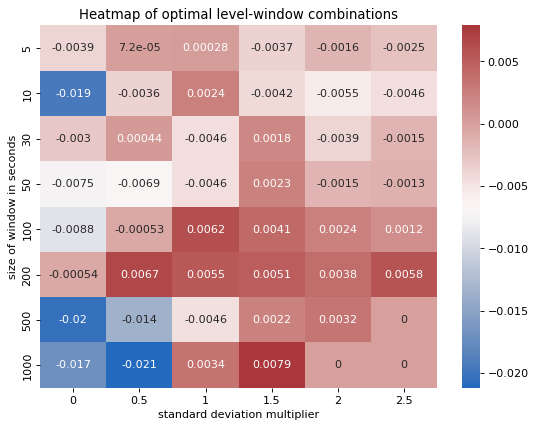

In [683]:
figure(figsize=(8, 6), dpi=80)
#sns.color_palette("vlag", as_cmap=True)
ma = sns.heatmap(optimal_parameters_long.values.tolist(),cmap="vlag",annot=True,xticklabels=[0,0.5,1,1.5,2,2.5], yticklabels=[5,10,30,50,100,200,500,1000])
ma.set(xlabel='standard deviation multiplier', ylabel='size of window in seconds',title = 'Heatmap of optimal level-window combinations')


This data is the training data, so we can select a pair that has a high pnl and isnt an anomaly, and run it on the testing data.
I have done this for the 9 dataframes for the 3 pairs, and these are the results we get:

In [914]:
dfs1 = [BTC_USD_2023,ETH_BTC_2023,ETH_USD_2023]
df2 = [BTC_USD_2022,ETH_BTC_2022,ETH_USD_2022]
df3 = [BTC_USD_2021,ETH_BTC_2021,ETH_USD_2021]
pnl1 = [0,0,0]
pnl2 = [0,0,0]
pnl3 = [0,0,0]

I run them seperately in these next few loops.

In [ ]:
for i in range(len(dfs1)):
    print('One done')
    pnl1[i] = find_optimal(dfs1[i],'long')

In [ ]:
for i in range(len(df2)):
    print('One done')
    pnl2[i] = find_optimal(df2[i],'long')

In [915]:
pnl3[1] = find_optimal(df3[1],'long')

1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1


In [924]:
pnl3[0] = find_optimal(df3[0],'long')

1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1


In [916]:
pnl3[2] = find_optimal(df3[2],'long')

1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1
1/8
lap 1
lap 1
lap 1
lap 1
lap 1
lap 1


In [897]:
len(BTC_USD_2022)

481629

In [895]:
VPIN(BTC_USD_2022, w, j)[0]['cumpnl'][-1]

0.0295383844138003

In [884]:
cols = ['BTC_USD_2023','ETH_BTC_2023','ETH_USD_2023','BTC_USD_2022','ETH_BTC_2022','ETH_USD_2022','BTC_USD_2021','ETH_BTC_2021','ETH_USD_2021']

final_results = pd.DataFrame(columns = cols , index = ['w','j','pnl'])

final_results['BTC_USD_2023'] = [pnl1[0][0],pnl1[0][1],VPIN(BTC_USD_2023,pnl1[0][0],pnl1[0][1])[0]['cumpnl'][-1]]
final_results['ETH_BTC_2023'] = [pnl1[1][0],pnl1[1][1],VPIN(ETH_BTC_2023,pnl1[1][0],pnl1[1][1])[0]['cumpnl'][-1]]
final_results['ETH_USD_2023'] = [pnl1[2][0],pnl1[2][1],VPIN(ETH_USD_2023,pnl1[2][0],pnl1[2][1])[0]['cumpnl'][-1]]

In [904]:
final_results['BTC_USD_2022'] = [pnl2[0][0],pnl2[0][1],VPIN(BTC_USD_2022,pnl2[0][0],pnl2[0][1])[0]['cumpnl'][-1]]
final_results['ETH_BTC_2022'] = [pnl2[1][0],pnl2[1][1],VPIN(ETH_BTC_2022,pnl2[1][0],pnl2[1][1])[0]['cumpnl'][-1]]
final_results['ETH_USD_2022'] = [pnl2[2][0],pnl2[2][1],VPIN(ETH_USD_2023,pnl2[2][0],pnl2[2][1])[0]['cumpnl'][-1]]

In [925]:
final_results['BTC_USD_2021'] = [pnl3[0][0],pnl3[0][1],VPIN(BTC_USD_2021,pnl3[0][0],pnl3[0][1])[0]['cumpnl'][-1]]
final_results['ETH_BTC_2021'] = [pnl3[1][0],pnl3[1][1],VPIN(ETH_BTC_2021,pnl3[1][0],pnl3[1][1])[0]['cumpnl'][-1]]
final_results['ETH_USD_2021'] = [pnl3[2][0],pnl3[2][1],VPIN(ETH_USD_2021,pnl3[2][0],pnl3[2][1])[0]['cumpnl'][-1]]

[[5, 0.0], [10, 0.0], [500, 0.5]]

In [927]:
storing_final = final_results

,BTC_USD_2023,ETH_BTC_2023,ETH_USD_2023,BTC_USD_2022,ETH_BTC_2022,ETH_USD_2022,BTC_USD_2021,ETH_BTC_2021,ETH_USD_2021
w,5.000000,10.000000,500.000000,100.000000,500.000000,200.000000,5.000000,30.000000,500.00000
j,0.000000,0.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.50000
pnl,0.007497,0.005154,0.004859,0.072866,0.011196,0.003356,0.615576,0.007352,0.02367


This is a great dataset. Firstly, all the returns are positive. This is a good indicator that our strategy seems robust. The fact that the 2023 data is still positive for a long-only strategy in a bear market is very attractive.
What we also see is that the strategy can achieve very decent results, such as 7% and more generally returns of around 1%.
By far the largest dataset, with over a million trades, BTC_USD_2021 returned 61%.
This is encouraging as it means that if the strategy is allowed to run for longer, it generates better resutls.

In [928]:
VPIN(BTC_USD_2021, 5, 0)[1]

60951

However, this was done in 61000 trades, which seems excessive. To make trades more impactful, I created the double down VPIN that follows.

# Double Down VPIN

This is an improved VPIN function. I realized that if we are already holding equity, but on our line the returns are higher than the level, being allowed to double down would most likely improve our pnl. I annotate the VPINdouble function below.

In [936]:
def VPINdouble(dataset, window, j):
    #this part calculates a rolling trade flow based on the window input
    dataset['rollingTradeflow'] = dataset['Tradeflow'].rolling(window,closed = 'left').sum()
    dataset=dataset.dropna(axis=0)
    
    #this part splits the data for training and testing purposes
    train, test = train_test_split(dataset, test_size=0.3,shuffle = False)
    beta = sm.OLS(train['returns'],train['rollingTradeflow']).fit().params[0]
    
    #this part predicts the returns with our beta and tradeflow
    test['pred_returns'] = test['rollingTradeflow'] * beta
    dataset = test
    
    #this is the calculation of the level and trigger
    levelhigh = dataset['pred_returns'].mean() + dataset['pred_returns'].std()*j
    levellow = dataset['pred_returns'].mean() + dataset['pred_returns'].std()*j/2

    dataset['trigger'] = np.where(dataset['pred_returns']>levelhigh, 1, 0)
    dataset['exit'] = np.where(dataset['pred_returns']>levellow, 1, 0)
    
    df = dataset.copy()
    df['Cash']=0.0
    df['Position']=0.0
    df['Pnl']=0.0
    
    #we need a cashtracker now to track the amount of cash that is being invested at one time
    cashtracker = 0
    maxcash = 0
    tradetracker = 0
    maxindex = 0
    
    for today in df.index:
        #if on first day we need to enter, then enter into a trade
        if today == df.index[0]:
            if df.loc[today,'trigger'] > 0:
                df.loc[today,'Position'] = 1 / df.loc[today,'PriceMillionths']
                df.loc[today,'Cash'] = - 1
                cashtracker += 1
                if cashtracker > maxcash:
                    maxcash = cashtracker
                tradetracker += 1
                
        #if on last day we still hold equity, sell it off
        elif today == df.index[-1]:
            if df.loc[yesterday,'Position'] >0.0:
                df.loc[today,'Cash'] = df.loc[yesterday,'Position'] * df.loc[today,'PriceMillionths'] 
                df.loc[today,'Position'] = 0.0
                df.loc[today,'Pnl'] = df.loc[today,'Cash'] - cashtracker
                cashtracker = 0
                tradetracker +1
                
        else:
            #if we are not holding anything and the expected future returns are high enough, enter trade
            if df.loc[today,'trigger'] > 0 and df.loc[yesterday,'Position']==0: 
                df.loc[today,'Position'] = 1 / df.loc[today,'PriceMillionths']
                df.loc[today,'Cash'] = - 1
                cashtracker += 1
                if cashtracker > maxcash:
                    maxcash = cashtracker
                    maxindex = today
                tradetracker += 1
                
            #if we are holding equity but the predicted returns are low enough, exit position
            elif df.loc[today,'exit'] == 0 and df.loc[yesterday,'Position']>0.0: 
                df.loc[today,'Cash'] = df.loc[yesterday,'Position'] * df.loc[today,'PriceMillionths']    
                df.loc[today,'Position'] = 0.0
                df.loc[today,'Pnl'] = df.loc[today,'Cash'] - cashtracker
                cashtracker = 0
                tradetracker += 1
                
            #if we are holding but the predicted returns are high, buy again
            elif df.loc[today,'trigger'] > 0 and df.loc[yesterday,'Position'] > 0.0:
                df.loc[today, 'Position'] = df.loc[yesterday,'Position'] +  1 / df.loc[today,'PriceMillionths']
                df.loc[today, 'Cash'] = -1
                cashtracker += 1
                if cashtracker > maxcash:
                    maxcash = cashtracker
                    maxindex = today
                tradetracker += 1
            
            #if the ticker is inside the range, below the trigger but above the sell point, hold
            else:
                df.loc[today,'Position'] = df.loc[yesterday,'Position'] 
            
        yesterday=today
    df['cumpnl'] = df['Pnl'].cumsum()
    tradetracker
    return [df,maxcash,tradetracker,maxindex]

Here is a sample output of the VPINdouble function.

In [935]:
dub = VPINdouble(BTC_USD_2023, 30, 0)

In [ ]:
dub[0].tail()

We are generateing 19% returns on 14000 trades.

Great results, however, we clearly have to take into account some form of trade cost per trade, and we are assuming that we can trade the close every day. My understanding is that this type of very fast trading has extremely low costs, so could be viable to do this number of trades over a day.

I'll conduct the same optimization approach I did with VPIN, looping around different windows and levels.

In [951]:
df1dub = [BTC_USD_2023,ETH_BTC_2023,ETH_USD_2023]
df2dub = [BTC_USD_2022,ETH_BTC_2022,ETH_USD_2022]
df3dub = [BTC_USD_2021,ETH_BTC_2021,ETH_USD_2021]
pnl1dub = [0,0,0]
pnl2dub = [0,0,0]
pnl3dub = [0,0,0]

In [952]:
for i in range(len(df1dub)):
    print('One done')
    pnl1dub[i] = find_optimal(df1dub[i],'double')

One done
1/8
1/8
1/8
1/8
1/8
1/8
1/8
One done
1/8
1/8
1/8
1/8
1/8
1/8
1/8
One done
1/8
1/8
1/8
1/8
1/8
1/8
1/8


In [953]:
for i in range(len(df2dub)):
    print('One done')
    pnl2dub[i] = find_optimal(df2dub[i],'double')

One done
1/8
1/8
1/8
1/8
1/8
1/8
1/8
One done
1/8
1/8
1/8
1/8
1/8
1/8
1/8
One done
1/8
1/8
1/8
1/8
1/8
1/8
1/8


In [974]:
pnl3dub[0] = find_optimal(df3dub[0],'double')

1/8
1/8
1/8
1/8


In [972]:
pnl3dub[1] = find_optimal(df3dub[1],'double')

1/8
1/8
1/8
1/8


In [973]:
pnl3dub[2] = find_optimal(df3dub[2],'double')

1/8
1/8
1/8
1/8


In [964]:
for i in range(len(df3dub)):
    print('One done')
    pnl3dub[i] = find_optimal(df3dub[i][:40000],'double')

One done
1/8
1/8
1/8
1/8
1/8
One done
1/8
1/8
1/8
1/8
1/8
One done
1/8
1/8
1/8
1/8
1/8


In [967]:
VPINdouble(BTC_USD_2021, 30, 0)[0]

,PriceMillionths,SizeBillionths,Tradeflow,returns,rollingTradeflow,pred_returns,trigger,exit,Cash,Position,Pnl,cumpnl
time,,,,,,,,,,,,
2021-04-10 21:57:04,5.904881e+10,13068970,-7.386686e+17,-3.607055e-05,3.928610e+19,8.892286e-07,1,1,-1.00000,1.693514e-11,0.00000,0.000000
2021-04-10 21:57:05,5.904883e+10,17849490,9.068837e+17,3.387028e-07,3.827603e+19,8.663659e-07,1,1,-1.00000,3.387028e-11,0.00000,0.000000
2021-04-10 21:57:06,5.904826e+10,61868480,-2.251514e+18,-9.653028e-06,3.914509e+19,8.860369e-07,1,1,-1.00000,5.080558e-11,0.00000,0.000000
2021-04-10 21:57:07,5.903896e+10,44040490,1.608577e+18,-1.574983e-04,3.693119e+19,8.359260e-07,1,1,-1.00000,6.774355e-11,0.00000,0.000000
2021-04-10 21:57:08,5.904412e+10,22988190,1.357320e+18,8.739991e-05,3.830254e+19,8.669660e-07,1,1,-1.00000,8.468003e-11,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-10 22:08:17,5.932902e+10,151100,8.964615e+15,0.000000e+00,3.823287e+19,8.653891e-07,1,1,-1.00000,1.348413e-10,0.00000,0.033964
2021-04-10 22:08:18,5.932901e+10,7630000,-4.526803e+17,-1.685516e-07,3.805046e+19,8.612603e-07,1,1,-1.00000,1.516964e-10,0.00000,0.033964
2021-04-10 22:08:19,5.932901e+10,3100610,-1.839561e+17,0.000000e+00,3.891593e+19,8.808499e-07,1,1,-1.00000,1.685516e-10,0.00000,0.033964


In [985]:
cols = ['BTC_USD_2023','ETH_BTC_2023','ETH_USD_2023','BTC_USD_2022','ETH_BTC_2022','ETH_USD_2022','BTC_USD_2021','ETH_BTC_2021','ETH_USD_2021']

final_resultsdub = pd.DataFrame(columns = cols , index = ['w','j','pnl','maxcash','trades'])

a = VPINdouble(BTC_USD_2023,pnl1dub[0][0],pnl1dub[0][1])
b = VPINdouble(ETH_BTC_2023,pnl1dub[1][0],pnl1dub[1][1])
c = VPINdouble(ETH_USD_2023,pnl1dub[2][0],pnl1dub[2][1])

d = VPINdouble(BTC_USD_2022,pnl2dub[0][0],pnl2dub[0][1])
e = VPINdouble(ETH_BTC_2022,pnl2dub[1][0],pnl2dub[1][1])
f = VPINdouble(ETH_USD_2022,pnl2dub[2][0],pnl2dub[2][1])

g = VPINdouble(BTC_USD_2021,pnl3dub[0][0],pnl3dub[0][1])
h = VPINdouble(ETH_BTC_2021,pnl3dub[1][0],pnl3dub[1][1])
i = VPINdouble(ETH_USD_2021,pnl3dub[2][0],pnl3dub[2][1])

In [987]:
final_resultsdub['BTC_USD_2023'] = [pnl1dub[0][0],pnl1dub[0][1],a[0]['cumpnl'][-1],a[1],a[2]]
final_resultsdub['ETH_BTC_2023'] = [pnl1dub[1][0],pnl1dub[1][1],b[0]['cumpnl'][-1],b[1],b[2]]
final_resultsdub['ETH_USD_2023'] = [pnl1dub[2][0],pnl1dub[2][1],c[0]['cumpnl'][-1],c[1],c[2]]

final_resultsdub['BTC_USD_2022'] = [pnl2dub[0][0],pnl2dub[0][1],d[0]['cumpnl'][-1],d[1],d[2]]
final_resultsdub['ETH_BTC_2022'] = [pnl2dub[1][0],pnl2dub[1][1],e[0]['cumpnl'][-1],e[1],e[2]]
final_resultsdub['ETH_USD_2022'] = [pnl2dub[2][0],pnl2dub[2][1],f[0]['cumpnl'][-1],f[1],f[2]]

final_resultsdub['BTC_USD_2021'] = [pnl3dub[0][0],pnl3dub[0][1],g[0]['cumpnl'][-1],h[1],h[2]]
final_resultsdub['ETH_BTC_2021'] = [pnl3dub[1][0],pnl3dub[1][1],h[0]['cumpnl'][-1],i[1],i[2]]
final_resultsdub['ETH_USD_2021'] = [pnl3dub[2][0],pnl3dub[2][1],i[0]['cumpnl'][-1],i[1],i[2]]

In [988]:
final_resultsdub

,BTC_USD_2023,ETH_BTC_2023,ETH_USD_2023,BTC_USD_2022,ETH_BTC_2022,ETH_USD_2022,BTC_USD_2021,ETH_BTC_2021,ETH_USD_2021
w,200.000000,100.000000,50.000000,500.000000,200.000000,200.000000,30.000000,500.000000,500.000000
j,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
pnl,0.654081,0.175877,0.075228,90.178364,9.016529,69.733238,1.534373,2.965222,17.685091
maxcash,1129.000000,106.000000,258.000000,3743.000000,774.000000,3539.000000,1003.000000,2136.000000,2136.000000
trades,13919.000000,126.000000,868.000000,62991.000000,12978.000000,88188.000000,3664.000000,16941.000000,16941.000000


This strategy has very large returns. However, we must underlign two things.
First of all, I intentionally did not set an upper limit on maxcash. I did this because, realistically, a higher maxcash will always be better than a lower one, so the limit should be set by the traders using the strategy and their risk tolerance. Since the base investment is 1 dollar, a 1129 maxcash means that you need to put in 1000 times more than you initially planned, which is huge. Also, the pnl is here in USD, which means that it cannot be interpreted as a percentage since we are sometimes investing more than one USD at a time. Finally, the number of trades is sometimes extremely high, which could create complications.

I also coded VPINshort, but it wasn't up to par with the other two strategies.

In [ ]:
def VPINshort(dataset, window, j):
    
    #this part calculates a rolling trade flow based on the window input
    dataset['rollingTradeflow'] = dataset['Tradeflow'].rolling(window,closed = 'left').sum()
    dataset=dataset.dropna(axis=0)
    
    #this part splits the data for training and testing purposes
    train, test = train_test_split(dataset, test_size=0.3,shuffle = False)
    beta = sm.OLS(train['returns'],train['rollingTradeflow']).fit().params[0]
    
    #this part predicts the returns with our beta and tradeflow
    test['pred_returns'] = test['rollingTradeflow'] * beta
    dataset = test
    
    #this is the calculation of the level and trigger
    buyhigh = dataset['pred_returns'].mean() + dataset['pred_returns'].std()*j
    buylow = dataset['pred_returns'].mean() + dataset['pred_returns'].std()*j/2
    
    sellhigh = dataset['pred_returns'].mean() - dataset['pred_returns'].std()*j
    selllow = dataset['pred_returns'].mean() - dataset['pred_returns'].std()*j/2
    
    dataset['trigger1'] = np.where(dataset['pred_returns']>buyhigh, 1, 0)
    dataset['trigger2'] = np.where(dataset['pred_returns']<sellhigh, -1, dataset['trigger1'])
    dataset['exit'] = np.where(dataset['pred_returns']>buylow, 1, 0)
    dataset['exit'] = np.where(dataset['pred_returns']<selllow, 1, dataset['exit'])
    
    df = dataset.copy()
    df['Cash']=0.0
    df['Position']=0.0
    df['Pnl']=0.0
    for today in df.index:
        if today == df.index[0]:
            if df.loc[today,'trigger2'] ==1:
                df.loc[today,'Position'] = 1 / df.loc[today,'PriceMillionths']
                df.loc[today,'Cash'] = - 1      
            if df.loc[today,'trigger2'] == -1:
                df.loc[today,'Position'] = -1 / df.loc[today,'PriceMillionths']
                df.loc[today,'Cash'] = 1   
        elif today == df.index[-1]:
            if df.loc[yesterday,'Position'] != 0.0:
                df.loc[today,'Cash'] = df.loc[yesterday,'Position'] * df.loc[today,'PriceMillionths'] 
                df.loc[today,'Position'] = 0.0
                #df.loc[today,'Pnl'] = df['Cash'].cumsum()
        else:
            if df.loc[today,'trigger2'] > 0 and df.loc[yesterday,'Position']==0: 
                df.loc[today,'Position'] = 1 / df.loc[today,'PriceMillionths']
                df.loc[today,'Cash'] = - 1
            elif df.loc[today,'trigger2'] < 0 and df.loc[yesterday,'Position']==0: 
                df.loc[today,'Position'] = - 1 / df.loc[today,'PriceMillionths']
                df.loc[today,'Cash'] = 1
            elif df.loc[today,'exit'] == 0 and df.loc[yesterday,'Position'] != 0.0: 
                df.loc[today,'Cash'] = df.loc[yesterday,'Position'] * df.loc[today,'PriceMillionths']    
                df.loc[today,'Position'] = 0.0
                #df.loc[today,'Pnl'] = df['Cash'].cumsum()
            else:
                df.loc[today,'Position'] = df.loc[yesterday,'Position'] 
        yesterday=today
    df['cumpnl']= df['Cash']
    return df

In [ ]:
optimal_parameters_short = pd.DataFrame(columns =[0,0.5,1,1.5,2,2.5] , index = [5,10,30,50,100,200,500])

for w in [5,10,30,50,100,200,500,1000]:
    for j in np.arange(0,2,0.5):
        optimal_parameters_long.loc[w,j] = VPINshort(BTC_USD_2023[:10000], w, j)['cumpnl'][-1]      

In [ ]:
figure(figsize=(8, 6), dpi=80)
#sns.color_palette("vlag", as_cmap=True)
ma = sns.heatmap(optimal_parameters_long.values.tolist(),cmap="vlag",annot=True,xticklabels=[0,0.5,1,1.5,2,2.5], yticklabels=[5,10,30,50,100,200,500])
ma.set(xlabel='standard deviation multiplier', ylabel='size of window in seconds',title = 'Heatmap of optimal level-window combinations')

In [ ]:
#this was storage in case I lost them - they take a while to run
storepnl1 = [[5, 0.0], [10, 0.0], [500, 0.5]]
storepnl2 = [[100,0.0],[500,1.0],[200,0.0]]
storepnl3 = [[5, 0.0], [30, 0.0], [500, 0.5]]